### Questions Type Categories 2 Labels

In this notebook we will have a look on how we can perform the previous task from the previous notebook using `CNN`. Also for the first time we are going to use the Functional API on `CNN`

We are going to change from Sequential to Functional API, the most of the code cells remains unchanged same, where there's change i will highlight.

### Imports

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import csv, json, time
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

tf.__version__

'2.5.0'

### GPU

In [2]:
devices = tf.config.list_physical_devices("GPU")
try:
  tf.config.experimental.set_visible_devices(devices[0], "GPU")
  print("GPU set")
except RuntimeError as e:
  print(e)

GPU set


### SEED

In [3]:
SEED = 42
tf.random.set_seed(
    SEED
)
np.random.seed(SEED)

### Mounting the google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data

Again we are not going to create files as we did in the last notebook, because all the data splits were done in the first notebook that's the reason we saved the csv files which have the following file names:

```
train.csv
test.csv
val.csv
```

In [6]:
data_path = "/content/drive/MyDrive/NLP Data/questions-classification"

### Loading the files

In [7]:
train_path = "train.csv"
val_path = "val.csv"
test_path = "test.csv"

In [8]:
train_dataframe = pd.read_csv(
    os.path.join(data_path, train_path)
)
val_dataframe = pd.read_csv(
    os.path.join(data_path, val_path)
)
test_dataframe = pd.read_csv(
    os.path.join(data_path, test_path)
)

As i said in this notebook we are going to predict two categories. So this means we are intrested in 3 columns for each set which are:

```
1. Questions  (feature)
2. Category0  (label_1)  (6 classes)                                                
3. Category2 (label_2) (47 classes)
```

In [9]:
train_dataframe.Category2.unique()

array(['dismed', 'count', 'ind', 'food', 'date', 'other', 'money', 'dist',
       'period', 'gr', 'perc', 'sport', 'country', 'city', 'desc', 'exp',
       'word', 'abb', 'cremat', 'animal', 'body', 'reason', 'def',
       'manner', 'letter', 'termeq', 'substance', 'state', 'color',
       'event', 'product', 'symbol', 'volsize', 'mount', 'weight', 'veh',
       'techmeth', 'plant', 'title', 'code', 'ord', 'speed', 'lang',
       'temp', 'instru', 'currency', 'religion'], dtype=object)

### Question Classes

In [10]:
train_dataframe.Category0.unique()

array(['ENTITY', 'NUMERIC', 'HUMAN', 'LOCATION', 'DESCRIPTION',
       'ABBREVIATION'], dtype=object)

We `6` different categories for these questions which are:
```
categories_0 = ['ENTITY', 'DESCRIPTION', 'NUMERIC', 'HUMAN', 'LOCATION',
       'ABBREVIATION']
```
We also have `47` classes of these questions which are:
```
categories_1 = ['dismed', 'count', 'ind', 'food', 'date', 'other', 'money', 'dist',
       'period', 'gr', 'perc', 'sport', 'country', 'city', 'desc', 'exp',
       'word', 'abb', 'cremat', 'animal', 'body', 'reason', 'def',
       'manner', 'letter', 'termeq', 'substance', 'state', 'color',
       'event', 'product', 'symbol', 'volsize', 'mount', 'weight', 'veh',
       'techmeth', 'plant', 'title', 'code', 'ord', 'speed', 'lang',
       'temp', 'instru', 'currency', 'religion']
```


### Features and Labels
* We are going to one_hot encode all labels

In [11]:
train_features = train_dataframe.Questions.values
train_labels_0 = train_dataframe.Category0.values
train_labels_1 = train_dataframe.Category2.values

test_features = test_dataframe.Questions.values
test_labels_0 = test_dataframe.Category0.values
test_labels_1 = test_dataframe.Category2.values

val_features = val_dataframe.Questions.values
val_labels_0 = val_dataframe.Category0.values
val_labels_1 = val_dataframe.Category2.values


### Label Encoding.

We are going to create encode the labels to numerical represantation using the `sklearn` `LabelEncoder` class. Since we have two labels we are going to create two surperate `LabelEncoder`'s

In [12]:
label_0_encoder = LabelEncoder()
label_0_encoder.fit(train_labels_0)

label_1_encoder = LabelEncoder()
label_1_encoder.fit(train_labels_1)

LabelEncoder()

Joining the validation and training set

In [13]:
train_valid_features = np.concatenate([train_features, val_features], axis = 0)
train_valid_labels_0 = np.concatenate([train_labels_0, val_labels_0], axis = 0)
train_valid_labels_1 = np.concatenate([train_labels_1, val_labels_1], axis = 0)

train_valid_labels_1.shape, train_valid_labels_0.shape, train_valid_features.shape

((4579,), (4579,), (4579,))

In [14]:
train_labels_0 = label_0_encoder.transform(train_valid_labels_0).astype("int32")
train_labels_1 = label_1_encoder.transform(train_valid_labels_1).astype("int32")

test_labels_0 = label_0_encoder.transform(test_labels_0).astype("int32")
test_labels_1 = label_1_encoder.transform(test_labels_1).astype("int32")


In [15]:
class_names_label_0 = label_0_encoder.classes_
class_names_label_1 = label_1_encoder.classes_


class_names_label_0.shape, class_names_label_1.shape

((6,), (47,))

### Next we are going to `one_hot_encode` labels.

We are only going to `one_hot` encode the train labels. We will also do the same to the test set so that it will act as our validation set since the dataset is very small. I'm going to use the `numpy` method `eye`. You can use the `sklearn` ``OneHotEncoder`` class or the `tensorflow` method `one_hot`.


**For this we will create two functions that one_hot_encode labels with different depth**


In [16]:
def one_hot_label_1(index, depth=6): # 6 classes
  return np.eye(depth, dtype=np.float32)[index]
print(one_hot_label_1(2))

def one_hot_label_2(index, depth=47): # 47 classes
  return np.eye(depth, dtype=np.float32)[index]
one_hot_label_2(2)

[0. 0. 1. 0. 0. 0.]


array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [17]:
train_labels_0_one_hot = np.array(list(map(one_hot_label_1, train_labels_0)))
test_labels_0_one_hot = np.array(list(map(one_hot_label_1, test_labels_0)))

train_labels_1_one_hot = np.array(list(map(one_hot_label_2, train_labels_1)))
test_labels_1_one_hot = np.array(list(map(one_hot_label_2, test_labels_1)))

In [18]:
test_labels_0_one_hot[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

### Features

 For now we are done with labels. In our case our feature is a question. All we need to do in this dataset is to create a helper function that will convert the text to lower case that's all we need. 

 After that we will then prepare/preprocess the train and validation features for the model.

In [19]:
to_lower = lambda sent: sent.lower()

In [20]:
train_features = np.array(
    list(
        map(to_lower, train_features)
    )
)
test_features= np.array(
    list(
        map(to_lower, test_features)
    )
)

In [21]:
train_features[:2]

array(['what does salk vaccine prevent ?',
       "how many times a day should you take a prescription marked `` q.i.d . '' ?"],
      dtype='<U196')

### Preprocessing Features(Questions)

1. Create a vocabulary
2. Create a `stoi` from each sentencs
3. pad the sentences to have the same size

**Note** - During creation of the vocabulary we are going to use the `train` set. The model should not have an idea about the validation set, because we want the validation set to represent the test set as mush as possible.

### Vocab size, (aka) the number of unique words.

I'm going to use spacy to tokenize each sentence and then we count number of unique words in the train set.

In [22]:
from collections import Counter
from nltk.tokenize import word_tokenize

In [23]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [24]:
train_features[0]

'what does salk vaccine prevent ?'

In [25]:
counter = Counter()
for sent in list(train_valid_features):
  words = word_tokenize(sent)
  for word in words:
    counter[word] += 1
counter.most_common(9)

[('?', 4494),
 ('the', 3045),
 ('What', 2729),
 ('is', 1417),
 ('of', 1309),
 ('in', 970),
 ('a', 863),
 ('How', 643),
 ("'s", 596)]

In [26]:
vocab_size = len(counter)
vocab_size

8475

We have `~8K` unique words in the train set. Next we are going to create word vectors.

### Word vectors

In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [28]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_valid_features)

In [29]:
word_indices = tokenizer.word_index
word_indices_reversed = dict([
    (v, k) for (k, v) in word_indices.items()
])

### Helper functions

We will create some helper function that converts sequences to text and text to sequences. These function will be used for inference later on.

In [30]:
def seq_to_text(sequences):
  return " ".join(word_indices_reversed[i] for i in sequences )

def text_to_seq(sent):
  words = word_tokenize(sent.lower())
  sequences = []
  for word in words:
    try:
      sequences.append(word_indices[word])
    except:
      sequences.append(0)
  return sequences

### Pretrained embeding weights

Since this model is using RNN's we are going to use the `pretrained glove.6B` word embeddings. I've already uploaded these word embedding on my google colab so that we can load them as follows

In [31]:
embedding_path = "/content/drive/MyDrive/NLP Data/glove.6B/glove.6B.100d.txt"


In [32]:
embedding_dict = dict()
with open(embedding_path, encoding="utf8") as glove:
  for line in glove:
    records = line.split();
    word = records[0]
    vectors = np.asarray(records[1: ], dtype=np.float32)
    embedding_dict[word] = vectors

In [33]:
print(len(embedding_dict))
embedding_dict["what"].shape

400000


(100,)

### But wait? `40000` words? Where are they comming from?
Okay don't panic we will create the embedding matrix that will suit our vocab_size next.

### Embedding matrix
We will then create an embedding matrix that will suit our data.

In [34]:
embedding_matrix = np.zeros((vocab_size, 100))

for word, index in word_indices.items():
  vector = embedding_dict.get(word)
  if vector is not None:
    try:
      embedding_matrix[index] = vector
    except IndexError or Exception:
      pass

In [35]:
len(embedding_matrix)

8475

Now the `embedding_matrix` suits our data which has `~8` words.

### Creating Sequences

In [36]:
train_sequences = tokenizer.texts_to_sequences(train_valid_features)
test_sequences = tokenizer.texts_to_sequences(test_features)

In [37]:
test_features[0], test_sequences[0]

('how many wings does a flea have ?', [7, 21, 1913, 17, 6, 41])

### Testing our helper functions

In [38]:
seq_to_text(test_sequences[0])

'how many wings does a have'

In [39]:
text_to_seq("this is why the unknownnnn word ?")

[517, 3, 44, 1, 0, 69, 0]

### Pad sequences

Our final step is to pad our suquences to have the same length. We are going to do this on the train and validation sets only.

In [40]:
max_words = 100

train_tokens_padded = pad_sequences(
    train_sequences, 
    maxlen=max_words, 
    padding="post", 
    truncating="post"
)
test_tokens_padded = pad_sequences(
    test_sequences, 
    maxlen=max_words, 
    padding="post", 
    truncating="post"
)

### Building the model.

Model Achitecture.

The model achitecture will be ploted

In [46]:
input_layer = keras.layers.Input(shape=(100, ))

embedding_layer = keras.layers.Embedding(
                  vocab_size, 100, 
                  input_length=max_words,
                  weights=[embedding_matrix], 
                  trainable=True,
                  name = "embedding_layer"
                )(input_layer)

cov_1d_1 =  keras.layers.Conv1D(
    64, 3, 1, activation="tanh", name ="conv_1d_1"
)(embedding_layer)

cov_1d_2 =  keras.layers.Conv1D(
    512, 3, 1, activation="tanh", name ="conv_1d_2"
)(cov_1d_1)

dropout_layer_1 = keras.layers.Dropout(rate=.5, name="dropout_layer_1")(cov_1d_2)
cov_1d_3 =  keras.layers.Conv1D(
    512, 3, 1, activation="tanh", name ="conv_1d_3"
)(dropout_layer_1)
cov_1d_4 =  keras.layers.Conv1D(
    128, 3, 1, activation="relu", name ="conv_1d_4"
)(cov_1d_3)
pooling_layer =  keras.layers.GlobalAveragePooling1D(
          name="average_pooling_layer"
        )(cov_1d_4)
dropout_layer_2 = keras.layers.Dropout(rate=.5, name="dropout_layer_2")(pooling_layer)

# FC hidden layers
dense_1 = keras.layers.Dense(64, activation='relu', name="dense_1")(dropout_layer_2)
dropout_layer_3 = keras.layers.Dropout(rate= .5, name="dropout_layer_3")(dense_1)
dense_2 = keras.layers.Dense(512, activation='relu', name="dense_2")(dense_1)
dropout_layer_4 = keras.layers.Dropout(rate= .5, name="dropout_layer_4")(dense_2)
dense_3 = keras.layers.Dense(128, activation='relu', name="dense_3")(dropout_layer_4)
dropout_3 = keras.layers.Dropout(rate= .5, name="dropout_layer_Y")(dense_3)

# Output_layer
output_1 = keras.layers.Dense(6, activation='softmax', name="output_1")(dropout_3)
output_2 = keras.layers.Dense(47, activation="softmax", name="output_2")(dropout_3)

question_category_model = keras.Model(inputs=input_layer, outputs=[output_1, output_2], name = "question_category_model") 

question_category_model.summary()

Model: "question_category_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 100, 100)     847500      input_5[0][0]                    
__________________________________________________________________________________________________
conv_1d_1 (Conv1D)              (None, 98, 64)       19264       embedding_layer[0][0]            
__________________________________________________________________________________________________
conv_1d_2 (Conv1D)              (None, 96, 512)      98816       conv_1d_1[0][0]                  
____________________________________________________________________________

### Let's plot the model and see it's stucture

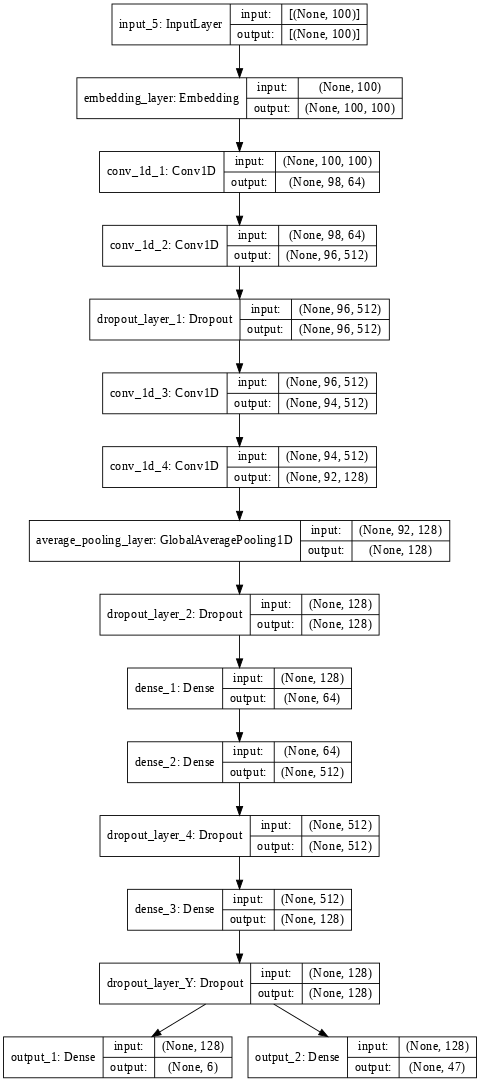

In [47]:
keras.utils.plot_model(question_category_model, dpi=64, show_shapes=True)

### Compiling the model

We are going two have two loss functions for each output label.

In [48]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_output_2_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
)

question_category_model.compile(
    loss = {
        "output_1" : keras.losses.CategoricalCrossentropy(from_logits=False),
        "output_2" : keras.losses.CategoricalCrossentropy(from_logits=False)
    },
    optimizer = keras.optimizers.Adam(1e-3, 0.5),
    metrics = ["accuracy"]
)

### How long should we train the model?
We are going to train the model for more epochs, as soon as the model loss stop decreasing we will stop.

In [49]:
EPOCHS = 50

history = question_category_model.fit(
    train_tokens_padded,
    y = [train_labels_0_one_hot, train_labels_1_one_hot],
    validation_data = (
        test_tokens_padded, [test_labels_0_one_hot, test_labels_1_one_hot],
    ),
    verbose = 1,
    epochs = EPOCHS,
    batch_size = 64,
    shuffle = True,
    validation_batch_size = 16,
    callbacks = [early_stopping]
)

Epoch 1/50
72/72 [==============================] - 35s 70ms/step - loss: 5.0325 - output_1_loss: 1.7181 - output_2_loss: 3.3144 - output_1_accuracy: 0.2295 - output_2_accuracy: 0.1542 - val_loss: 4.5492 - val_output_1_loss: 1.5426 - val_output_2_loss: 3.0066 - val_output_1_accuracy: 0.3471 - val_output_2_accuracy: 0.2119
Epoch 2/50
72/72 [==============================] - 4s 59ms/step - loss: 4.4779 - output_1_loss: 1.5216 - output_2_loss: 2.9564 - output_1_accuracy: 0.3608 - output_2_accuracy: 0.2468 - val_loss: 4.2612 - val_output_1_loss: 1.3827 - val_output_2_loss: 2.8784 - val_output_1_accuracy: 0.4261 - val_output_2_accuracy: 0.2990
Epoch 3/50
72/72 [==============================] - 5s 63ms/step - loss: 4.2290 - output_1_loss: 1.4198 - output_2_loss: 2.8092 - output_1_accuracy: 0.4355 - output_2_accuracy: 0.2776 - val_loss: 3.9869 - val_output_1_loss: 1.3017 - val_output_2_loss: 2.6852 - val_output_1_accuracy: 0.4696 - val_output_2_accuracy: 0.2921
Epoch 4/50
72/72 [============

### Plotting the model's training history.

In [50]:
import matplotlib.pyplot as plt

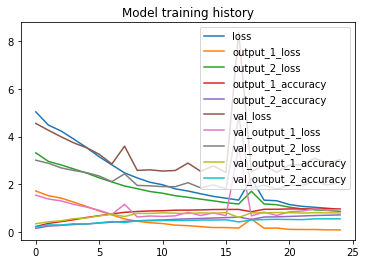

In [51]:
df = pd.DataFrame(history.history)
df.plot(title="Model training history")
plt.show()

### Converting test data to numeric and then pad it.

In [52]:
def text_to_padded_sequences(sent):
  tokens = text_to_seq(sent)
  padded_tokens = pad_sequences([tokens], maxlen=max_words, padding="post", truncating="post")
  return tf.squeeze(padded_tokens)

question_category_model.evaluate(
    test_tokens_padded, [test_labels_0_one_hot, test_labels_1_one_hot],
    verbose = 1,
    batch_size = 32
)

28/28 [==============================] - 0s 13ms/step - loss: 3.0299 - output_1_loss: 0.9518 - output_2_loss: 2.0782 - output_1_accuracy: 0.7950 - output_2_accuracy: 0.5510


[3.029937505722046,
 0.9517647624015808,
 2.0781729221343994,
 0.7949599027633667,
 0.550973653793335]

As we can see that we are able to get an accuracy of `~80%` on the first category and `~55%` accuracy on the second category of the test data. Which can be improved by having a lot of train examples as well as balancing the data in the train set.

And as we also know that `CNN` are bad for sequence data. This is proved because this model gives us `~10%` lower accuracy that the `RNN` model.

### Model inference (making predictions)

In [57]:
from prettytable import PrettyTable

In [58]:
def tabulate(column_names, data, max_characters:int, question:str):
  table = PrettyTable(column_names)
  table.align[column_names[0]] = "l"
  table.align[column_names[1]] = "l"
  table.align[column_names[2]] = "l"
  table.title = question
  table._max_width = {column_names[0] :max_characters, column_names[1] :max_characters, column_names[2] :max_characters}
  for row in data:
    table.add_row(row)
  print(table)

In [59]:
def predict(model, sent, real_label_1, real_label_2):
  classes_1 = class_names_label_0
  classes_2 = class_names_label_1
  tokens = text_to_seq(sent)
  padded_tokens = pad_sequences([tokens], maxlen=max_words, 
                                padding="post", truncating="post")
  
  probabilities_1, probabilities_2 = model.predict(padded_tokens)

  prediction_1 = tf.argmax(probabilities_1, axis=1).numpy()[0]
  class_name_1 = classes_1[prediction_1]
  prediction_2 = tf.argmax(probabilities_2, axis=1).numpy()[0]
  class_name_2 = classes_2[prediction_2]

  table_headers =["KEY", "CATEGORY 1", "CATEGORY 2"]
  table_data = [
        ["PREDICTED CLASS",  prediction_1,  prediction_2],
        ["PREDICTED CLASS NAME",  class_name_1, class_name_2],
        ["REAL CLASS",  real_label_1, real_label_2],
        ["REAL CLASS NAME",  classes_1[real_label_1], classes_2[real_label_2]],
        ["CONFIDENCE OVER OTHER CLASSES", f'{probabilities_1[0][prediction_1] * 100:.2f}%', f'{probabilities_2[0][prediction_2] * 100:.2f}%'],
             
    ]
  tabulate(table_headers, table_data, 50, sent)

### Making predictions on the test data.

In [60]:
for label_1, label_2, sent in zip(test_labels_0[:10], test_labels_1, test_features):
  predict(question_category_model, sent, real_label_1=label_1, real_label_2= label_2)

+---------------------------------------------------------+
|            how many wings does a flea have ?            |
+-------------------------------+------------+------------+
| KEY                           | CATEGORY 1 | CATEGORY 2 |
+-------------------------------+------------+------------+
| PREDICTED CLASS               | 5          | 6          |
| PREDICTED CLASS NAME          | NUMERIC    | count      |
| REAL CLASS                    | 5          | 6          |
| REAL CLASS NAME               | NUMERIC    | count      |
| CONFIDENCE OVER OTHER CLASSES | 100.00%    | 99.25%     |
+-------------------------------+------------+------------+
+---------------------------------------------------------+
|                who is samuel pickering ?                |
+-------------------------------+------------+------------+
| KEY                           | CATEGORY 1 | CATEGORY 2 |
+-------------------------------+------------+------------+
| PREDICTED CLASS               | 3     

### Confusion matrix.

That's the end of this series for this week.